# Etapa 1. Turismo de los alpes

El procesamiento de lenguaje natural funciona de varias formas diferentes. El NLP basado en AI involucra el uso de algoritmos de machine learning y técnicas para procesar, comprender y generar lenguaje humano.

## 1. Entendimiento y preparación de los datos

Este es el proceso de limpiar y preparar el texto para que un algoritmo de NLP pueda analizarlo. Algunas técnicas de preprocesamiento de datos comunes incluyen la minería de texto, que toma grandes cantidades de texto y las divide en datos, o la tokenización, que divide el texto en unidades individuales. Estas unidades pueden ser puntuación, palabras o frases. La eliminación de palabras vacías es una herramienta que elimina palabras comunes y artículos del discurso que no son muy útiles en el análisis. La derivación y lematización descomponen las palabras hasta su forma raíz básica, lo que facilita identificar su significado. El etiquetado de categoría gramatical identifica sustantivos, verbos, adjetivos y otras categorías en una oración. El parseo analiza la estructura de una oración y cómo las distintas palabras se relacionan entre sí. [1]

### 1.1 Importación de librerías

In [91]:
import pandas as pd
import numpy as np
import re

#Natural Toolkit Language
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

from sklearn.svm import SVC
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

### 1.2 Entendimiento de los datos

In [41]:
#Natural Language Toolkit

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
df = pd.read_csv('tipo1_entrenamiento_estudiantes.csv')

In [43]:
df.head(20)

,Review,Class
0,Nos alojamos en una casa alquilada en la ciuda...,4
1,"La comida está bien, pero nada especial. Yo te...",3
2,"En mi opinión, no es una como muchos usuarios ...",3
3,esta curiosa forma que asemeja una silla de mo...,4
4,Lo mejor era la limonada. Me gusto la comida d...,2
5,Carol K. \n\nNo me sorprende que el comentario...,2
6,Nos gustó mucho pero hicimos fila enorme para ...,4
7,Un hotel muy limpio con un personal de segurid...,1
8,"Subiendo las escaleras, puede encontrar un bar...",4
9,"Llegamos el 17 de febrero, hicimos el check in...",1


In [44]:
df.describe()

,Class
count,7875.000000
mean,3.491683
std,1.328275
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [45]:
len(df)

7875

Lo anterior muestra una muestra de los datos, con una cantidad total de reseñas de 7875 y se encontraron que muchas palabras estan mal escritas o escritas coloquialmente como es pq y q, que son respectivamente porque y que, asimismo, las palabras con tildes estan mal escritas como es: estÃ¡

<Axes: xlabel='Class'>

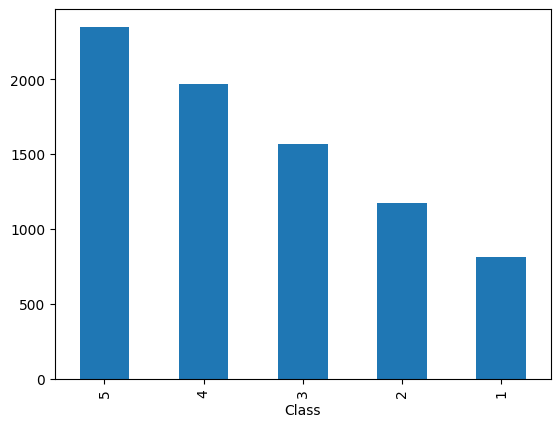

In [46]:
df["Class"].value_counts().plot(kind='bar')

Se observó en la gráfica que hay más calificaciones ("reviews") fue 5, y el última fue 1. 

In [47]:
# Conteo de datos duplicados
duplicados = df.duplicated().sum()
print("Cantidad de datos duplicados:", duplicados)

# Conteo de datos nulos por columna
nulos_por_columna = df.isnull().sum()
print("Cantidad de datos nulos por columna:")
print(nulos_por_columna)


Cantidad de datos duplicados: 71
Cantidad de datos nulos por columna:
Review    0
Class     0
dtype: int64


Identificamos también los datos duplicados y datos nulos, donde no se mostraron que no se encontraron. 

c:\Users\maria\Documents\Universidad de los Andes\202410\Inteligencia de Negocios\Proyecto\Proyecto 1\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


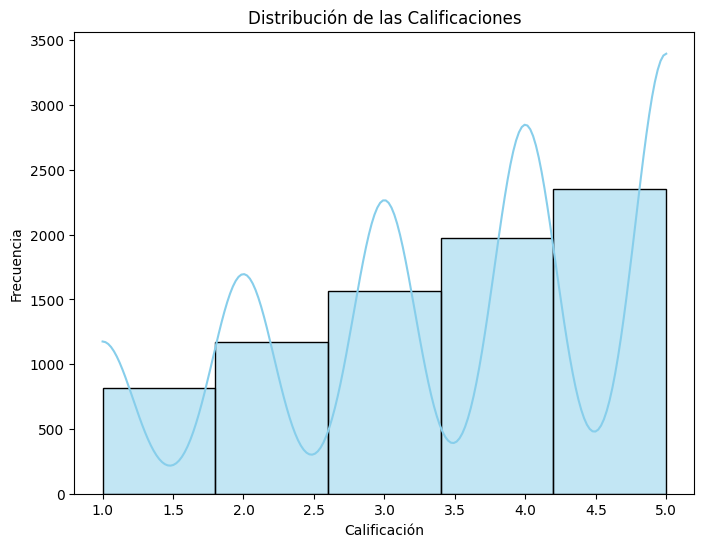

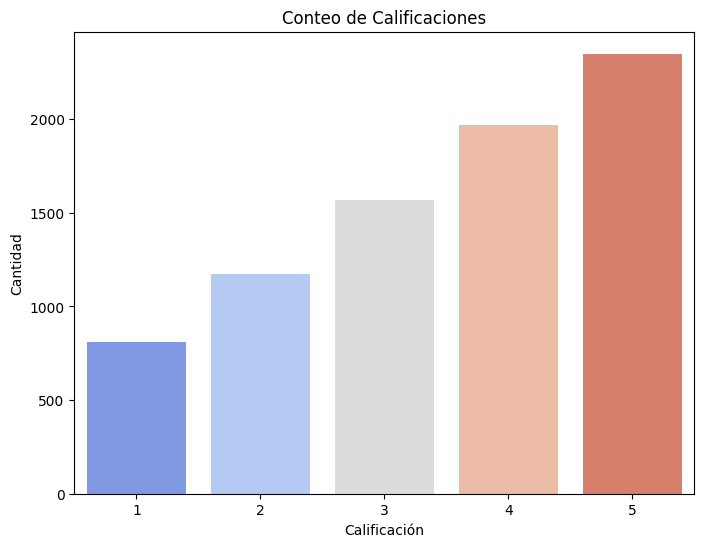

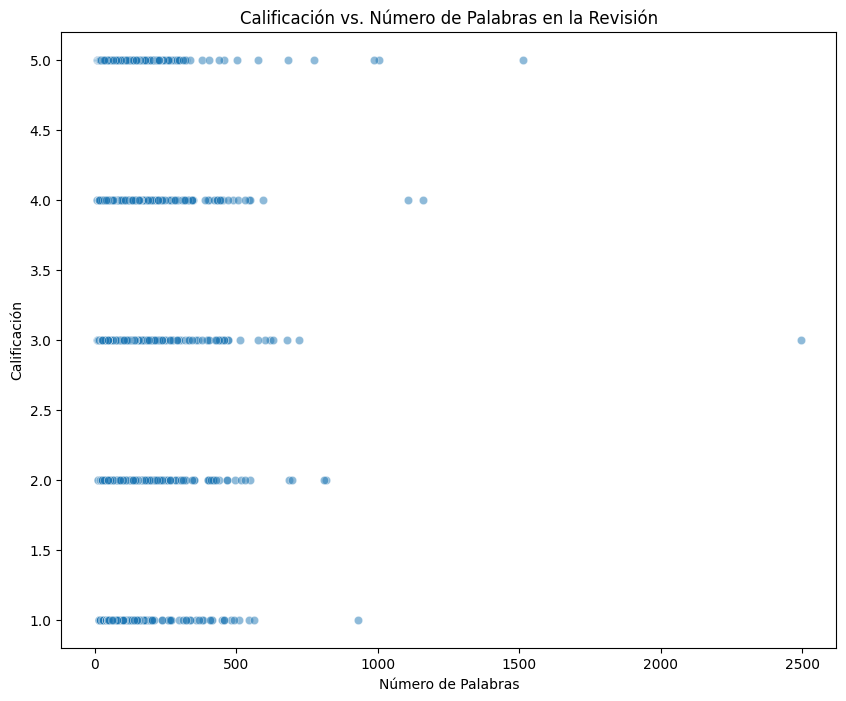

In [48]:
# Histograma de las calificaciones
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Class', bins=5, kde=True, color='skyblue')
plt.title('Distribución de las Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras de las calificaciones
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Class', palette='coolwarm')
plt.title('Conteo de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')
plt.show()

# Diagrama de dispersión de las calificaciones en función del número de palabras en la revisión
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x=df['Review'].apply(lambda x: len(x.split())), y='Class', alpha=0.5)
plt.title('Calificación vs. Número de Palabras en la Revisión')
plt.xlabel('Número de Palabras')
plt.ylabel('Calificación')
plt.show()

### 1.2 Preparación de los datos

Primero se van a escribir las decisiones de transformación y preparación de los datos y posteriormente se realizará cada uno.

Decisión 1: Limpieza de caracteres

Se limpian todas las reseñas de símbolos y se convierten en minúsculas. Esto debido a que las mayúsculas no se consideran como información valiosa y tildes mal puestas. 

In [49]:
import unicodedata

def preprocessor(text):
    # Eliminar etiquetas HTML
    text = re.sub('<[^>]*>', '', text)
    
    # Eliminar tildes y otros caracteres especiales
    text = ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Encontrar emoticones
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # Eliminar caracteres no alfanuméricos y agregar emoticones
    text = re.sub('[\W]+', ' ', text) + ' '.join(emoticons).replace('-', '')
    
    return text.split()

Decisión 2: Separación de las palabras. Para establecer la relación entre positivo y negativo para un futuro análisis. 

In [50]:
palabras_positivas = ['bueno', 'maravilloso', 'excelente', 'genial', 'increíble']
palabras_negativas = ['malo', 'pobre', 'horrible', 'decepcionante', 'terrible']

Decisión 3: Separación dataframe en train y test

In [51]:
new = df.copy()

X, Y = new['Review'], new['Class']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,Y,
                                        train_size = 0.90,
                                        random_state=0
                                        ) 

In [52]:
X_train = X_train.apply(preprocessor)
X_test = X_test.apply(preprocessor)

In [53]:
X_train.head()

6538    [ubicado, en, una, bonita, zona, de, la, bogot...
1715    [pasamos, 4, noches, aqui, en, febrero, como, ...
6811    [lindo, lugar, muy, pintoresco, esa, zona, es,...
7587    [llegamos, a, este, hotel, despues, de, salir,...
4019    [un, sitio, que, no, te, puedes, perder, si, v...
Name: Review, dtype: object

Decisión 4: Con el Natural Language Toolkit se procede a eliminar las palabras que no tienen gran significado para este análisis, estas son palabras como: articulos, preposiciones, pronombres, entre otros. Que de igual manera no nos brindan información de gran utilidad pues en muchos casos son neutros o no aportan mucho.

In [54]:
#Se utiliza el filtro de stopwords en español
stop = stopwords.words('spanish')

def remove_stopwords(text):
    tokenized = [w for w in text if w not in stop]
    return tokenized

In [55]:
X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

In [56]:
X_train.head()

6538    [ubicado, bonita, zona, bogota, antigua, edifi...
1715    [pasamos, 4, noches, aqui, febrero, parte, tou...
6811    [lindo, lugar, pintoresco, zona, ideal, camina...
7587    [llegamos, hotel, despues, salir, corriendo, h...
4019    [sitio, puedes, perder, si, visitas, habana, l...
Name: Review, dtype: object

Decisión 5: Creación de vocabulario y conteo de ocurrencias

Crear un vocabulario de todas las palabras presentes en las reseñas del conjunto de entrenamiento. El vocabulario se crea contando cuántas veces aparece cada palabra en todas las reseñas.

In [57]:
from collections import Counter
#Se cuentan las ocurrencias de las palabras en todas las reseñas
vocabulary = Counter()

for review in X_train:
    vocabulary.update(review)

In [58]:
#Se muestran las 5 palabras mas comunes
vocabulary.most_common()[:5]

[('hotel', 3451),
 ('mas', 3182),
 ('si', 2136),
 ('lugar', 2131),
 ('comida', 2009)]

In [59]:
len(vocabulary)

23144

Decisión 6: Vectorización de texto. 

Este paso se realiza debido a que, muchos algoritmos de aprendizaje automático, como las redes neuronales y las máquinas de vectores de soporte (SVM), requieren que las entradas sean en forma numérica. La vectorización convierte el texto en vectores numéricos que pueden ser utilizados por estos algoritmos para entrenar modelos.

In [60]:
# Unir los tokens en cadenas de texto
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_v = tfidf_vectorizer.fit_transform(X_train_str)
X_test_v = tfidf_vectorizer.transform(X_test_str)


In [61]:
# Convertir matriz dispersa a DataFrame
X_train_df = pd.DataFrame(X_train_v.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Imprimir un preview grande del DataFrame
print(X_train_df.head(10))

    00  000   05   08        10  100   11   12   13   14  ...  yucatecos  \
0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
1  0.0  0.0  0.0  0.0  0.101075  0.0  0.0  0.0  0.0  0.0  ...        0.0   
2  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
3  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
4  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
5  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
6  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
7  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
8  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   
9  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  ...        0.0   

   zapatos  zen  zipaquira  zocalo      zona  zonas  zoologico  zumo  zumos  
0      0.0  0.0        0.0     0.0  0.105968    0.0        0.0   0.0    0.0  
1      

Los valores en la tabla representan el peso TF-IDF de cada palabra en cada revisión. TF-IDF es una medida estadística que evalúa la importancia de una palabra en un documento en relación con un corpus de documentos. Un valor alto indica que la palabra es importante para esa revisión específica, mientras que un valor bajo indica que la palabra es menos relevante. Por el contrario, las palabras con un valor de TF-IDF bajo o cercano a cero pueden no ser tan relevantes para esa revisión en particular.

Por ejemplo, en la primera fila, la palabra "zona" tiene un valor de TF-IDF de aproximadamente 0.105923, lo que sugiere que esta palabra es relativamente importante en esa revisión específica en comparación con otras palabras en esa revisión y en el corpus general de revisiones.

## 2. Modelado

### 2.1 Support Vector Machine (SVM)

Maria Alejandra Estrada García 

202021060

Para esto primero se va a realizar un análisis de sentimientos usando Clasificación de Texto con SVM. Para analizar las reseñas de los sitios turísticos y determinar el sentimiento asociado con cada una (positivo, neutral, negativo). Esto permitiría identificar características específicas que influyen en la satisfacción del turista y determinar qué aspectos contribuyen a la popularidad de un sitio turístico y cuáles afectan su reputación negativamente. En otras palabras, un SVM lleva a cabo la clasificación encontrando el hiperplano que maximiza el margen entre clases. Los vectores (muestras) que definen el hiperplano (decision boundary) son los vectores de soporte. Por otro lado, todas las muestras ubicadas a un lado de la frontera de decisión serán clasificadas con valores positivos igual o mayores que uno. Análogamente, todas las muestras ubicadas al otro lado de la frontera de deción serán clasificadas con valores negativos iguales o menores que menos uno. 

### 2.1.1 Búsqueda de hiperparámetros

Para realizar la visualización de los datos y las diferentes clases junto con los support vectors en un SVM, primero necesitamos ajustar los hiperparámetros adecuados para cada tipo de kernel (lineal y RBF). Luego, podemos utilizar técnicas de reducción de dimensionalidad como PCA para visualizar los datos en un espacio bidimensional. Después de eso, podemos entrenar los modelos SVM con los datos reducidos y visualizar las diferentes clases junto con los vectores de soporte.

Para la elección del kernel depende de la naturaleza de los datos y del problema en cuestión. Adicionalmente, ajustar el parámetro de regularización es importante para controlar el compromiso entre la complejidad del modelo y su capacidad para generalizar.  El parámetro gamma tiene un efecto significativo en la forma del límite de decisión. 

Ajuste de hiperparámetros para SVM con kernel lineal

In [71]:
# Definir los parámetros a ajustar
parameters_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Crear una instancia del clasificador SVM con kernel lineal
svm_linear = SVC(kernel='linear', random_state=42)

# Crear una instancia de GridSearchCV
grid_search_linear = GridSearchCV(svm_linear, parameters_linear, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Realizar la búsqueda de hiperparámetros
grid_search_linear.fit(X_train_v, y_train)

# Obtener los mejores hiperparámetros
best_params_linear = grid_search_linear.best_params_
print("Mejores hiperparámetros para SVM con kernel lineal:", best_params_linear)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros para SVM con kernel lineal: {'C': 1}


El valor óptimo encontrado para el parámetro de regularización C es de 1 que indica que el modelo busca un equilibrio entre clasificar correctamente los puntos de entrenamiento y mantener una buena capacidad de generalización en nuevos datos.

Ajuste de hiperparámetros para SVM con kernel RBF

In [ ]:
# Escalar los datos utilizando MaxAbsScaler
scaler_rbf = MaxAbsScaler()
X_train_scaled_rbf = scaler_rbf.fit_transform(X_train_v)

# Definir los parámetros a ajustar
parameters_rbf = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# Crear una instancia del clasificador SVM con kernel RBF
svm_rbf = SVC(kernel='rbf', random_state=42)

# Crear una instancia de GridSearchCV
grid_search_rbf = GridSearchCV(svm_rbf, parameters_rbf, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Realizar la búsqueda de hiperparámetros
grid_search_rbf.fit(X_train_scaled_rbf, y_train)

# Obtener los mejores hiperparámetros
best_params_rbf = grid_search_rbf.best_params_
print("Mejores hiperparámetros para SVM con kernel RBF:", best_params_rbf)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros para SVM con kernel RBF: {'C': 1, 'gamma': 0.1}


Los hiperparámetros óptimos encontrados son C = 1 y gamma = 0.1. Estos valores indican que se prefiere una penalización moderada (C = 1) y un valor de gamma que sugiere un compromiso entre la flexibilidad del modelo y su capacidad de generalización. Con gamma = 0.1, el modelo RBF tiene suficiente flexibilidad para capturar las relaciones no lineales en los datos, pero no es tan flexible como para sobreajustarlos.

### 2.1.2 SVM

El modelo SVM tiene una precisión general del 46.8%, lo que indica que puede clasificar correctamente aproximadamente el 47% de las muestras en el conjunto de prueba. 

SVM usando Kernel Linear:

Se usan los hiperparámetros encontrados anteriormente (C=1.0)

In [72]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear una instancia del clasificador SVM con kernel lineal
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)

# Entrenar el modelo SVM con kernel lineal
svm_linear.fit(X_train_v, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_linear = svm_linear.predict(X_test_v)

# Evaluar la precisión del modelo
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print("Precisión del modelo SVM con kernel lineal:", accuracy_linear)

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_linear))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_linear))


Precisión del modelo SVM con kernel lineal: 0.467005076142132

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.53      0.32      0.39        92
           2       0.29      0.29      0.29       103
           3       0.38      0.43      0.40       154
           4       0.39      0.42      0.40       183
           5       0.64      0.65      0.64       256

    accuracy                           0.47       788
   macro avg       0.45      0.42      0.43       788
weighted avg       0.47      0.47      0.47       788


Matriz de Confusión:
[[ 29  40  15   3   5]
 [ 17  30  39  12   5]
 [  7  17  66  40  24]
 [  1  10  35  76  61]
 [  1   6  18  64 167]]


El modelo SVM con kernel lineal tiene una precisión del 46.7%. Sin embargo, su rendimiento varía entre las diferentes clases, siendo más bajo para las clases 1, 2 y 3 en comparación con las clases 4 y 5. Esto sugiere que el modelo podría beneficiarse de mejoras o de la consideración de otras técnicas de clasificación para lograr un rendimiento más equilibrado entre las clases.

SVM usando Kernel RBF:

Se usan los hiperparámetros encontrados anteriormente (C=1.0 y gamma=0.1)

In [83]:
# Preprocesar los datos (escalar para el kernel RBF)
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_v)
X_test_scaled = scaler.transform(X_test_v)

# Crear una instancia del clasificador SVM con kernel RBF
svm_rbf = SVC(kernel='rbf', C=1.0, gamma=0.1, random_state=42)

# Entrenar el modelo SVM con kernel RBF
svm_rbf.fit(X_train_scaled, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Evaluar la precisión del modelo
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("Precisión del modelo SVM con kernel RBF:", accuracy_rbf)

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rbf))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rbf))

Precisión del modelo SVM con kernel RBF: 0.4746192893401015

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.71      0.22      0.33        92
           2       0.31      0.33      0.32       103
           3       0.37      0.39      0.38       154
           4       0.40      0.44      0.42       183
           5       0.63      0.70      0.66       256

    accuracy                           0.47       788
   macro avg       0.48      0.42      0.42       788
weighted avg       0.49      0.47      0.47       788


Matriz de Confusión:
[[ 20  42  19   8   3]
 [  6  34  42  11  10]
 [  1  21  60  43  29]
 [  1   8  30  81  63]
 [  0   6  11  60 179]]


El modelo SVM con kernel RBF alcanza una precisión del 47.5%. Observamos que la precisión varía entre las clases, siendo más baja para la clase 1 en comparación con las clases 4 y 5. Esto sugiere que el modelo podría beneficiarse de una mejora en el rendimiento para algunas clases específicas.

Gráficas de cada SVM para visualizar mejor los resultados

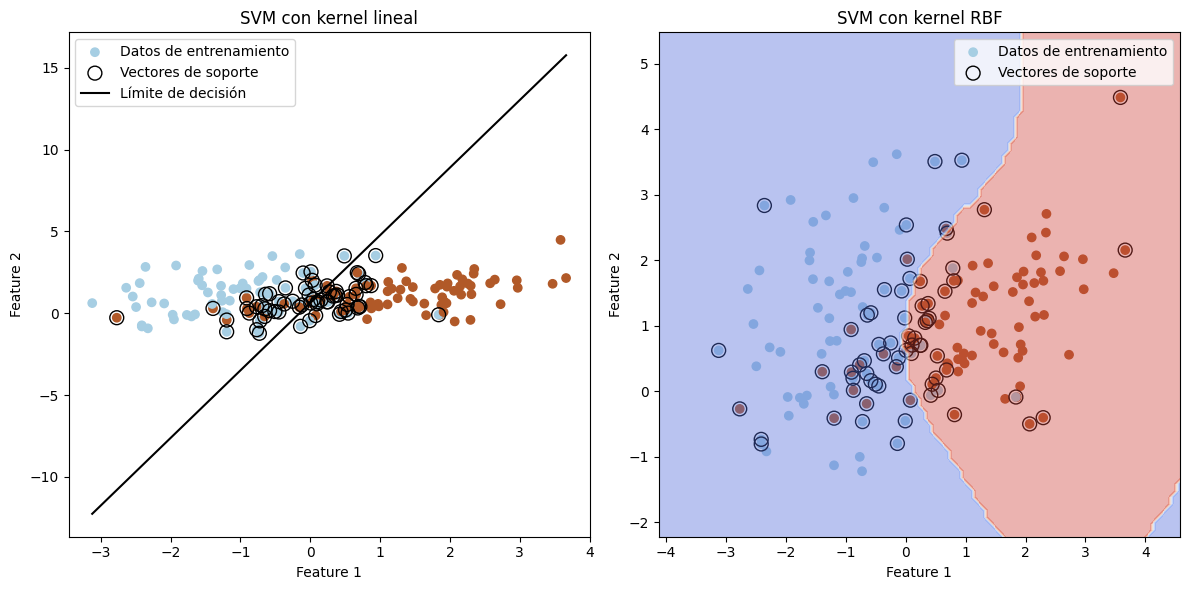

In [94]:
# Scatter plot de las clases y los vectores de soporte
plt.figure(figsize=(12, 6))

# Clase y vectores de soporte para SVM lineal
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, label='Datos de entrenamiento')
plt.scatter(svm_linear.support_vectors_[:, 0], svm_linear.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', label='Vectores de soporte')
w = svm_linear.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]))
yy = a * xx - (svm_linear.intercept_[0]) / w[1]
plt.plot(xx, yy, 'k-', label='Límite de decisión')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM con kernel lineal')
plt.legend()

# Clase y vectores de soporte para SVM RBF
plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, label='Datos de entrenamiento')
plt.scatter(svm_rbf.support_vectors_[:, 0], svm_rbf.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', label='Vectores de soporte')

# Crear una malla para plotear la curva de decisión del kernel RBF
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = svm_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotear la curva de decisión
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM con kernel RBF')
plt.legend()

plt.tight_layout()
plt.show()


Observamos una clara separación entre las dos clases principales de reseñas. Las reseñas clasificadas como negativas tienden a agruparse en el lado izquierdo, mientras que las reseñas clasificadas como positivas se encuentran en el lado derecho. Esto sugiere que el modelo SVM ha logrado identificar patrones distintivos que diferencian las reseñas negativas de las positivas. Asimismo, los vectores de soporte, que son los puntos de datos más cercanos al límite de decisión del modelo, están bien distribuidos y se encuentran principalmente en las áreas de transición entre las dos clases.

### 2.2 Random Forest

Marilyn Stephany Joven Fonseca

202021346

Este método se basa en la construcción de múltiples árboles de decisión durante el entrenamiento y combina sus predicciones para obtener una predicción más precisa y robusta. En nuestro contexto, Random Forest nos permitirá identificar las características más relevantes que inciden en la satisfacción del turista y la popularidad de los destinos turísticos. Al evaluar la importancia de variables como la ubicación, las instalaciones, los servicios y las reseñas de los turistas, seremos capaces de descubrir patrones y tendencias que contribuyan a entender mejor qué aspectos determinan el éxito de un sitio turístico.

In [ ]:
p_features = X_train_str.fit_transform(p_features).toarray()

### 2.3 Logistic Regression

Santiago Martínez Novoa

202112020

Este algoritmo estima las probabilidades asociadas con cada clase y utiliza una función logística para predecir la probabilidad de que una instancia pertenezca a una clase específica. En nuestro análisis turístico, la Regresión Logística nos permitirá predecir la probabilidad de que un sitio turístico reciba una calificación positiva, neutral o negativa en función de sus características específicas. Esto nos ayudará a identificar qué factores tienen un mayor impacto en la satisfacción del turista y en la reputación del destino turístico, así como a desarrollar estrategias para mejorar la experiencia del turista y promover el turismo de manera más efectiva.

## 3. Evaluación

##  4. Resultados

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=353f6407-fc37-4ee9-8dc3-56903a752cdb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>